## Panel data

This notebook contains our implementation of the panel data regression. Thanks to: https://towardsdatascience.com/a-guide-to-panel-data-regression-theoretics-and-implementation-with-python-4c84c5055cf8 for Python implementation of panel data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stat

In [2]:
# reading in processed data
df_fin = pd.read_csv('df_financial.csv', index_col=0)
df_fin.head()

,Company,constant,year,score,total,market_cap,growth,excess_return
0,3M,1,2017,2.719205,7537,123796.0,0.051413,0.174235
1,3M,1,2018,2.234604,8099,125568.5,0.035000,-0.099849
2,3M,1,2019,2.859970,8215,106199.5,-0.019197,-0.331689
3,3M,1,2020,2.866892,7996,101136.5,0.001494,-0.134937
4,3M,1,2021,3.529180,9147,101591.5,0.098527,-0.220422


In [3]:
# checking if we have any nan values in the dataset
df1 = df_fin[df_fin.isna().any(axis=1)]
df1.head()

# dropping rows with nan values
df_fin = df_fin[df_fin.Company!="CardinalHealth"]

In [4]:
# dropping companies where we discovered mistakes in preprocessing
drop_companies = ['Carnival', 'Aescorporation']
df_fin = df_fin[~df_fin.Company.isin(drop_companies)]

In [5]:
# dropping wors with total sentences < 200
# this is because after inpection this probably is due to 
# problems in the reading of the report
companies = df_fin[df_fin.total<200]['Company'].values
df_fin = df_fin[~df_fin.Company.isin(companies)]

In [6]:
# sorting scores to find best perfromers
df_fin[df_fin.year == 2021].sort_values(by='score', ascending=False, na_position='first')

,Company,constant,year,score,total,market_cap,growth,excess_return
4,3M,1,2021,3.529180,9147,101591.5,0.098527,-0.220422
104,Cigna,1,2021,3.443798,5115,75657.5,0.085268,-0.146029
359,P_G,1,2021,3.323801,8264,370433.5,0.072840,-0.063710
244,Johnson_Johnson,1,2021,2.936121,5148,432334.0,0.135511,-0.154546
9,Abbott,1,2021,2.389215,11414,214482.5,0.244654,0.036356
...,...,...,...,...,...,...,...,...
14,Accenture,1,2021,-0.822995,435,191781.5,0.140005,0.337726
414,Starbucks,1,2021,-0.836841,873,128479.0,0.235649,-0.166522
239,J.M.Smucker,1,2021,-0.873763,706,14112.5,0.025766,-0.058475
409,Stanley,1,2021,-1.097602,430,29680.0,0.196063,-0.196111


R-squared: 0.761029


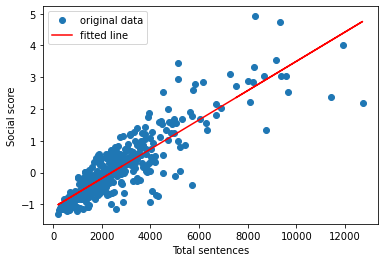

In [7]:
# making scatterplot of social score and total number of sentences
# regressing a fitted line
x=df_fin['total']
y=df_fin['score']

slope, intercept, r, p, se = stat.linregress(x, y)

print(f"R-squared: {r**2:.6f}")

plt.plot(x, y, 'o', label='original data')
plt.xlabel('Total sentences')
plt.ylabel('Social score')
plt.plot(x, intercept + slope*x, 'r', label='fitted line')
plt.legend()
plt.show()

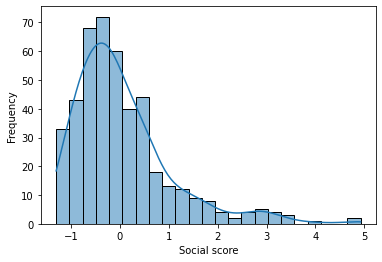

In [30]:
# histogram of social scores
import seaborn as sns
fig, ax = plt.subplots(1,1,figsize = (6,4))
sns.histplot(y, ax=ax, kde=True)
ax.set_xlabel('Social score')
ax.set_ylabel('Frequency')
plt.show()


<AxesSubplot:>

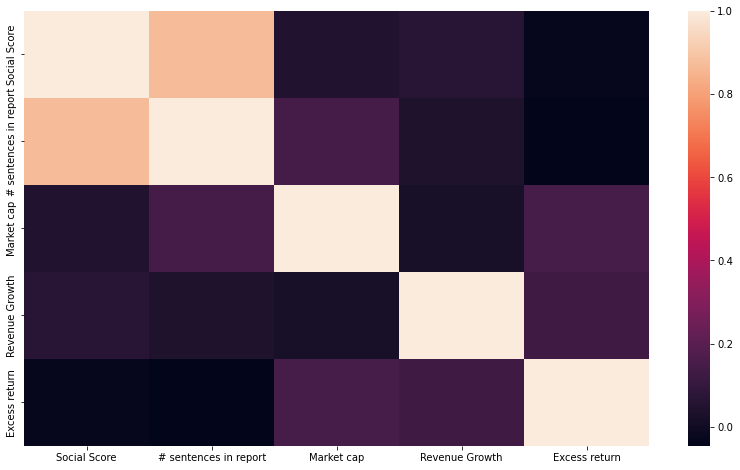

In [64]:
# creating a heat map to check correlation

corr_features = ['score', 'total', 'market_cap',
                 'growth', 'excess_return'
                 ]
df_corr = df_fin[corr_features]
corr = df_corr.corr()
corr['score']
f, ax = plt.subplots(figsize=(14,8))
labels = ['Social Score', '# sentences in report', 'Market cap', 'Revenue Growth', 'Excess return']
sns.heatmap(corr, ax=ax, xticklabels= labels, yticklabels = labels)

In [49]:
corr['score']

score            1.000000
total            0.872370
market_cap       0.046908
growth           0.065793
excess_return   -0.032936
Name: score, dtype: float64

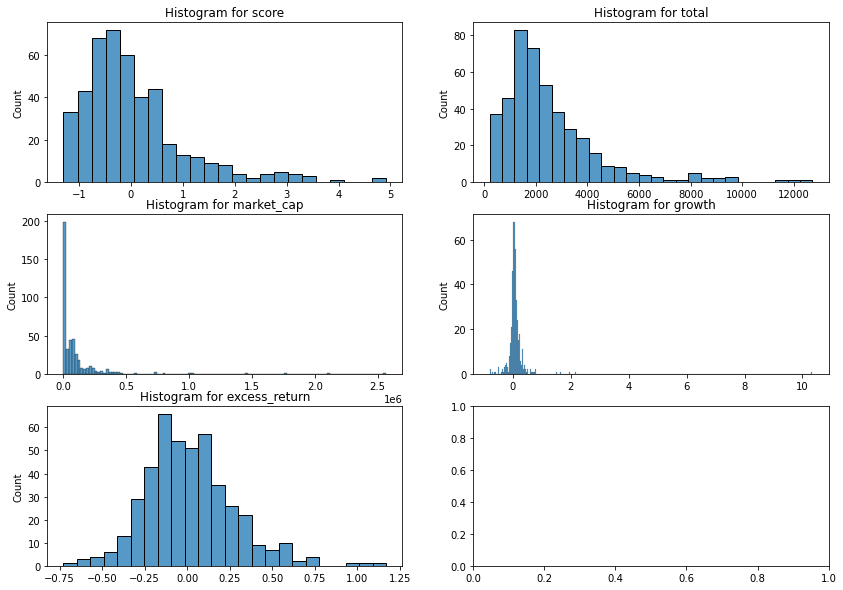

In [50]:
# inspecting all the variables
fix, ax = plt.subplots(3,2, figsize=(14,10))
for i, element in enumerate(corr_features):
    sns.histplot(df_fin[element].values, ax = ax[i//2, i%2])
    ax[i//2, i%2].set_title(f"Histogram for {element}")
    

First, we try performing pooled OLS

In [55]:
# we standarize market cap to make it have the same magnitude as the other variables
df_fin['market_cap'] = (df_fin['market_cap']-df_fin['market_cap'].mean())/df_fin['market_cap'].std()

In [56]:
from linearmodels import PooledOLS
from datetime import datetime

import statsmodels.api as sm

features = ['constant', 'score', 'market_cap', 'growth']

df_fin['year'] = pd.to_datetime(df_fin['year'], format='%Y')
df_fin2 = df_fin.set_index(['Company', 'year'], append=False)

exog = df_fin2[features]

endog = df_fin2['excess_return']
mod = PooledOLS(endog, exog)
pooledOLS_res = mod.fit(cov_type='clustered', cluster_entity=True)
# Store values for checking homoskedasticity graphically
fittedvals_pooled_OLS = pooledOLS_res.predict().fitted_values
residuals_pooled_OLS = pooledOLS_res.resids

In [57]:
print(pooledOLS_res)

                          PooledOLS Estimation Summary                          
Dep. Variable:          excess_return   R-squared:                        0.0405
Estimator:                  PooledOLS   R-squared (Between):              0.1736
No. Observations:                 445   R-squared (Within):              -0.0154
Date:                Wed, Jun 08 2022   R-squared (Overall):              0.0405
Time:                        08:40:00   Log-likelihood                   -28.899
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      6.1970
Entities:                          89   P-value                           0.0004
Avg Obs:                       5.0000   Distribution:                   F(3,441)
Min Obs:                       5.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             14.590
                            

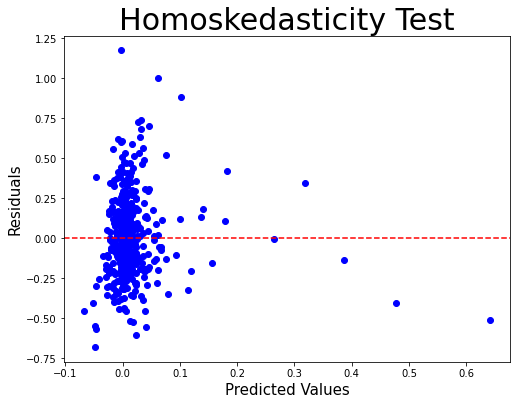

In [58]:
# 3A. Homoskedasticity
import matplotlib.pyplot as plt
 # 3A.1 Residuals-Plot for growing Variance Detection
fig, ax = plt.subplots(figsize = (8,6))
ax.scatter(fittedvals_pooled_OLS, residuals_pooled_OLS, color = 'blue')
ax.axhline(0, color = 'r', ls = '--')
ax.set_xlabel('Predicted Values', fontsize = 15)
ax.set_ylabel('Residuals', fontsize = 15)
ax.set_title('Homoskedasticity Test', fontsize = 30)
plt.show()

In [59]:
# FE und RE model
from linearmodels import PanelOLS
from linearmodels import RandomEffects

exog = df_fin2[['constant', 'score', 'market_cap', 'growth']]

# random effects model
model_re = RandomEffects(endog, exog) 
re_res = model_re.fit() 
# fixed effects model
model_fe = PanelOLS(endog, exog, entity_effects = True, drop_absorbed=True) 
fe_res = model_fe.fit() 
#print results
print(re_res)

                        RandomEffects Estimation Summary                        
Dep. Variable:          excess_return   R-squared:                        0.0318
Estimator:              RandomEffects   R-squared (Between):              0.1617
No. Observations:                 445   R-squared (Within):              -0.0110
Date:                Wed, Jun 08 2022   R-squared (Overall):              0.0401
Time:                        08:40:50   Log-likelihood                   -16.235
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4.8228
Entities:                          89   P-value                           0.0026
Avg Obs:                       5.0000   Distribution:                   F(3,441)
Min Obs:                       5.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             4.8228
                            

In [61]:
print(fe_res)

                          PanelOLS Estimation Summary                           
Dep. Variable:          excess_return   R-squared:                        0.0061
Estimator:                   PanelOLS   R-squared (Between):             -0.0461
No. Observations:                 445   R-squared (Within):               0.0061
Date:                Wed, Jun 08 2022   R-squared (Overall):             -0.0093
Time:                        08:40:50   Log-likelihood                    41.211
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.7239
Entities:                          89   P-value                           0.5383
Avg Obs:                       5.0000   Distribution:                   F(3,353)
Min Obs:                       5.0000                                           
Max Obs:                       5.0000   F-statistic (robust):             0.7239
                            

Hausman test to find the best model.

In [62]:
import numpy.linalg as la
from scipy import stats
import numpy as np
def hausman(fe, re):
 b = fe.params
 B = re.params
 v_b = fe.cov
 v_B = re.cov
 df = b[np.abs(b) < 1e8].size
 chi2 = np.dot((b - B).T, la.inv(v_b - v_B).dot(b - B)) 
 
 pval = stats.chi2.sf(chi2, df)
 return chi2, df, pval

hausman_results = hausman(fe_res, re_res) 
print('Chi-Squared: ' + str(hausman_results[0]))
print('degrees of freedom: ' + str(hausman_results[1]))
print('p-Value: ' + str(hausman_results[2]))

Chi-Squared: 22.144607186086233
degrees of freedom: 4
p-Value: 0.00018756413393888912
